In [16]:
from kafka import KafkaConsumer
import joblib
from river import drift
import pandas as pd
from json import loads
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from statistics import mean
from tqdm import tqdm
plt.style.use('seaborn-darkgrid')

In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    consumer_timeout_ms=10000, # To avoid infinite loop once the data stream ends.
    value_deserializer=lambda m: loads(m.decode('utf-8')),
    enable_auto_commit=False
)


# Import static model

In [3]:
static_model = joblib.load('trained_rf_top_k_features.pkl')

In [4]:
# Our starting point is the static model. 
dynamic_model_only_1k_window =  RandomForestClassifier(random_state=0,n_estimators= 200, max_depth= None, warm_start=False) 
dynamic_model_1k_plus_dynamic_data_so_far =  RandomForestClassifier(random_state=0, n_estimators=200, max_depth=None, warm_start=False) 
dynamic_model_all_data_so_far =  joblib.load('trained_rf_top_k_features.pkl') # A copy of the static model



## Additional Feature Creation Functions

These functions are copied from the static model notebook.

In [5]:
def single_char_longest_word(x):
    if len(x) != 1:
        return -1
    else:
        if x.isnumeric():
            return int(x)
        else:
            return ord(x)
def three_char_sld(x):
    if len(x) == 3 and x.isnumeric():
        return int(x)
    else:
        return -1

In [6]:
static_data = pd.read_csv("Static_dataset.csv")

In [7]:
original_columns = static_data.columns
static_data["Target Attack"] = static_data["Target Attack"].apply(int)
static_data["longest_word"] = static_data["longest_word"].fillna('')
static_data["sld"] = static_data["sld"].fillna('')
static_data["longest_word_length"] = static_data["longest_word"].apply(len)
static_data["longest_word_single_char"] =static_data["longest_word"].apply(single_char_longest_word)
static_data["sld_length"] = static_data["sld"].apply(len)
static_data["sld_three_char"] = static_data["sld"].apply(three_char_sld)
static_data["longest_word_islower"] = static_data["longest_word"].apply(lambda x: str(x).islower())
static_data["longest_word_isupper"] = static_data["longest_word"].apply(lambda x: str(x).isupper())
static_data["longest_word_isnumeric"] = static_data["longest_word"].apply(lambda x: str(x).isnumeric())
static_data["longest_word_isalnum"] = static_data["longest_word"].apply(lambda x: str(x).isalnum())
static_data["sld_islower"] = static_data["sld"].apply(lambda x: str(x).islower())
static_data["sld_isupper"] = static_data["sld"].apply(lambda x: str(x).isupper())
static_data["sld_isnumeric"] = static_data["sld"].apply(lambda x: str(x).isnumeric())
static_data["sld_isalnum"] = static_data["sld"].apply(lambda x: str(x).isalnum())

In [8]:
features_to_use = ['FQDN_count',
  'subdomain_length',
  'lower',
  'numeric',
  'entropy',
  'special',
  'labels',
  'len',
  'longest_word_length',
  'sld_length',
  'longest_word_islower',
  'longest_word_isnumeric',
  'sld_islower',
  'sld_isnumeric',
  'sld_isalnum',
  'sld_three_char',
  'longest_word_single_char']

# Reading the data stream and performing the re-training scheme:

In [9]:
data_read = []
PRECISION_THRESHOLD = 0.72
RECALL_THRESHOLD = 0.98

static_accuracies = []
static_precisions = []
static_recalls = []

dynamic_accuracies_only_1k = []
dynamic_precisions_only_1k = []
dynamic_recalls_only_1k = []

dynamic_accuracies_1k_plus_dynamic_so_far = []
dynamic_precisions_1k_plus_dynamic_so_far = []
dynamic_recalls_1k_plus_dynamic_so_far = []

dynamic_accuracies_all_data = []
dynamic_precisions_all_data = []
dynamic_recalls_all_data = []

ensemble_accuracies = []
ensemble_precisions = []
ensemble_recalls = []

WINDOW_SIZE = 1000
records_read = 0

kswin = drift.KSWIN(window_size=WINDOW_SIZE, alpha=0.00005)
kswin_drift_indices = []

for i,m in enumerate(tqdm(consumer)):
    if "timestamp" in m.value and "FQDN_count" in m.value: #Ignore the line with the columns
        continue
    datum = m.value
    data_read.append(datum.split(","))
    records_read += 1
    _ = kswin.update(m.value)
    
    if kswin.drift_detected:
        print(f"Change detected at index {i}, input value: {m.value}")
        kswin_drift_indices.append(i)
        
    if records_read % WINDOW_SIZE == 0:
        dynamic_dataset = pd.DataFrame(data_read, columns=original_columns)
        for col in original_columns:
            if col != "Target Attack":
                dynamic_dataset[col] = dynamic_dataset[col].astype(type(static_data[col].iloc[0]))
        dynamic_dataset["Target Attack"] = dynamic_dataset["Target Attack"].apply(int)
        dynamic_dataset["longest_word_length"] = dynamic_dataset["longest_word"].apply(len)
        dynamic_dataset["longest_word_single_char"] =dynamic_dataset["longest_word"].apply(single_char_longest_word)
        dynamic_dataset["sld_length"] = dynamic_dataset["sld"].apply(len)
        dynamic_dataset["sld_three_char"] = dynamic_dataset["sld"].apply(three_char_sld)
        dynamic_dataset["longest_word_islower"] = dynamic_dataset["longest_word"].apply(lambda x: str(x).islower())
        dynamic_dataset["longest_word_isupper"] = dynamic_dataset["longest_word"].apply(lambda x: str(x).isupper())
        dynamic_dataset["longest_word_isnumeric"] = dynamic_dataset["longest_word"].apply(lambda x: str(x).isnumeric())
        dynamic_dataset["longest_word_isalnum"] = dynamic_dataset["longest_word"].apply(lambda x: str(x).isalnum())
        dynamic_dataset["sld_islower"] = dynamic_dataset["sld"].apply(lambda x: str(x).islower())
        dynamic_dataset["sld_isupper"] = dynamic_dataset["sld"].apply(lambda x: str(x).isupper())
        dynamic_dataset["sld_isnumeric"] = dynamic_dataset["sld"].apply(lambda x: str(x).isnumeric())
        dynamic_dataset["sld_isalnum"] = dynamic_dataset["sld"].apply(lambda x: str(x).isalnum())
        
        X = dynamic_dataset[features_to_use][records_read-WINDOW_SIZE:records_read]
        y = dynamic_dataset["Target Attack"][records_read-WINDOW_SIZE:records_read]
        predictions = pd.DataFrame()
        predictions["Target Attack"] = y
        
        if records_read == WINDOW_SIZE:            
            # This if-block handles the first window when the models are not yet trained
            dynamic_accuracies_only_1k.append(0)
            dynamic_accuracies_1k_plus_dynamic_so_far.append(0)
            dynamic_precisions_only_1k.append(0)
            dynamic_precisions_1k_plus_dynamic_so_far.append(0)
            dynamic_recalls_only_1k.append(0)
            dynamic_recalls_1k_plus_dynamic_so_far.append(0)
            predictions["dynamic_model_only_1k_window"] = 0
            predictions["dynamic_model_1k_plus_dynamic_data_so_far"] = 0
            dynamic_model_only_1k_window.fit(X, y)
            dynamic_model_1k_plus_dynamic_data_so_far.fit(X,y)            
        else:
            dynamic_accuracies_only_1k.append(dynamic_model_only_1k_window.score(X,y))
            dynamic_precisions_only_1k.append(precision_score(y, dynamic_model_only_1k_window.predict(X)))
            dynamic_recalls_only_1k.append(recall_score(y, dynamic_model_only_1k_window.predict(X)))
            
            dynamic_accuracies_1k_plus_dynamic_so_far.append(dynamic_model_1k_plus_dynamic_data_so_far.score(X,y))
            dynamic_precisions_1k_plus_dynamic_so_far.append(precision_score(y, dynamic_model_1k_plus_dynamic_data_so_far.predict(X)))
            dynamic_recalls_1k_plus_dynamic_so_far.append(recall_score(y, dynamic_model_1k_plus_dynamic_data_so_far.predict(X)))
            
            predictions["dynamic_model_only_1k_window"] = dynamic_model_only_1k_window.predict(X)
            predictions["dynamic_model_1k_plus_dynamic_data_so_far"] = dynamic_model_1k_plus_dynamic_data_so_far.predict(X)
            
        static_accuracies.append(static_model.score(X,y))
        static_precisions.append(precision_score(y, static_model.predict(X)))
        static_recalls.append(recall_score(y, static_model.predict(X)))
        
        dynamic_accuracies_all_data.append(dynamic_model_all_data_so_far.score(X,y))
        dynamic_precisions_all_data.append(precision_score(y, dynamic_model_all_data_so_far.predict(X)))
        dynamic_recalls_all_data.append(recall_score(y, dynamic_model_all_data_so_far.predict(X)))
                
        predictions["static"] = static_model.predict(X)      
        predictions["dynamic_model_all_data_so_far"] = dynamic_model_all_data_so_far.predict(X)
        predictions['majority'] = predictions.mode(axis=1)[0]
        
        ensemble_accuracies.append(accuracy_score(predictions["Target Attack"], predictions["majority"]))
        ensemble_precisions.append(precision_score(predictions["Target Attack"], predictions["majority"]))
        ensemble_recalls.append(recall_score(predictions["Target Attack"], predictions["majority"]))
        
        # Re-training based on the thresholds.
        if dynamic_precisions_all_data[-1] < PRECISION_THRESHOLD or dynamic_recalls_all_data[-1] < RECALL_THRESHOLD:
            print(f"Retraining Model Trained on all data. Records read so far = {records_read}")
            all_train_data_X = pd.concat([dynamic_dataset[features_to_use], static_data[features_to_use]])
            all_train_data_y = pd.concat([dynamic_dataset["Target Attack"], static_data["Target Attack"]])
            dynamic_model_all_data_so_far.fit(all_train_data_X, all_train_data_y)
        if dynamic_precisions_only_1k[-1] < PRECISION_THRESHOLD or dynamic_recalls_only_1k[-1] < RECALL_THRESHOLD:
            print(f"Retraining Model Trained only on window. Records read so far = {records_read}")
            dynamic_model_only_1k_window =  RandomForestClassifier(random_state=0, n_estimators=200, max_depth= None, warm_start=False) 
            dynamic_model_only_1k_window.fit(X, y)
        if dynamic_precisions_1k_plus_dynamic_so_far[-1] < PRECISION_THRESHOLD or dynamic_recalls_1k_plus_dynamic_so_far[-1] < RECALL_THRESHOLD:
            print(f"Retraining Model Trained on window + all dynamic data read so far. Records read so far = {records_read}")
            dynamic_model_1k_plus_dynamic_data_so_far.fit(dynamic_dataset[features_to_use], dynamic_dataset["Target Attack"])
        

1it [00:00,  2.72it/s]

Retraining Model Trained only on window. Records read so far = 1000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 1000


3265it [00:04, 712.16it/s] 

Change detected at index 3352, input value: 10:44.5,27,10,0,10,11,2.481480463,6,6,7,3.666666667,2,192,14,1,1



6625it [00:07, 998.84it/s] 

Retraining Model Trained only on window. Records read so far = 7000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 7000


19476it [00:25, 776.69it/s] 

Change detected at index 19638, input value: 56:24.5,27,10,0,10,11,2.767194749,6,6,7,3.666666667,2,192,14,1,1



31936it [00:42, 975.13it/s] 

Retraining Model Trained on all data. Records read so far = 32000


31936it [01:00, 975.13it/s]

Retraining Model Trained only on window. Records read so far = 32000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 32000


32870it [01:18, 64.65it/s] 

Retraining Model Trained only on window. Records read so far = 33000


75587it [02:33, 603.79it/s]

Change detected at index 75550, input value: 05:57.5,23,0,0,21,0,3.50583169,2,2,19,11,javascript,javascript-minifier,20,0,0



86601it [02:55, 559.30it/s]

Retraining Model Trained on all data. Records read so far = 87000


86601it [03:10, 559.30it/s]

Retraining Model Trained only on window. Records read so far = 87000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 87000


99759it [04:16, 599.01it/s]

Retraining Model Trained on all data. Records read so far = 100000


99759it [04:30, 599.01it/s]

Retraining Model Trained only on window. Records read so far = 100000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 100000


107996it [05:27, 640.03it/s]

Retraining Model Trained only on window. Records read so far = 108000


112621it [05:39, 505.92it/s]

Retraining Model Trained on all data. Records read so far = 113000


112621it [05:50, 505.92it/s]

Retraining Model Trained only on window. Records read so far = 113000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 113000


113858it [06:34, 48.91it/s] 

Retraining Model Trained only on window. Records read so far = 114000


138919it [07:38, 488.36it/s]

Change detected at index 138950, input value: 58:58.1,10,0,0,9,0,2.125,1,2,7,4.5,tver,tverreg,8,0,0



152456it [08:16, 390.36it/s]

Change detected at index 152808, input value: 30:32.6,7,0,0,6,0,1.857542476,1,2,4,3,slow,slow,5,0,0



160856it [08:38, 533.65it/s]

Retraining Model Trained on all data. Records read so far = 161000


160856it [08:50, 533.65it/s]

Retraining Model Trained only on window. Records read so far = 161000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 161000


205610it [12:06, 348.53it/s]

Retraining Model Trained on all data. Records read so far = 206000


205610it [12:21, 348.53it/s]

Retraining Model Trained only on window. Records read so far = 206000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 206000


224655it [14:34, 327.49it/s]

Retraining Model Trained on all data. Records read so far = 225000


224655it [14:51, 327.49it/s]

Retraining Model Trained only on window. Records read so far = 225000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 225000


225868it [16:04, 29.59it/s] 

Retraining Model Trained only on window. Records read so far = 226000


226681it [16:08, 54.58it/s]

Change detected at index 226981, input value: 43:12.2,26,9,0,10,10,2.742337624,6,6,7,3.5,2,192,13,1,1



252473it [17:45, 257.52it/s]

Change detected at index 252838, input value: 17:26.3,26,9,0,10,10,2.742337624,6,6,7,3.5,2,192,13,1,1



264920it [18:34, 389.90it/s]

Retraining Model Trained on all data. Records read so far = 265000


264920it [18:51, 389.90it/s]

Retraining Model Trained only on window. Records read so far = 265000
Retraining Model Trained on window + all dynamic data read so far. Records read so far = 265000


268065it [20:49, 214.47it/s]


# Plotting the evaluation metrics:

## Accuracy plots:

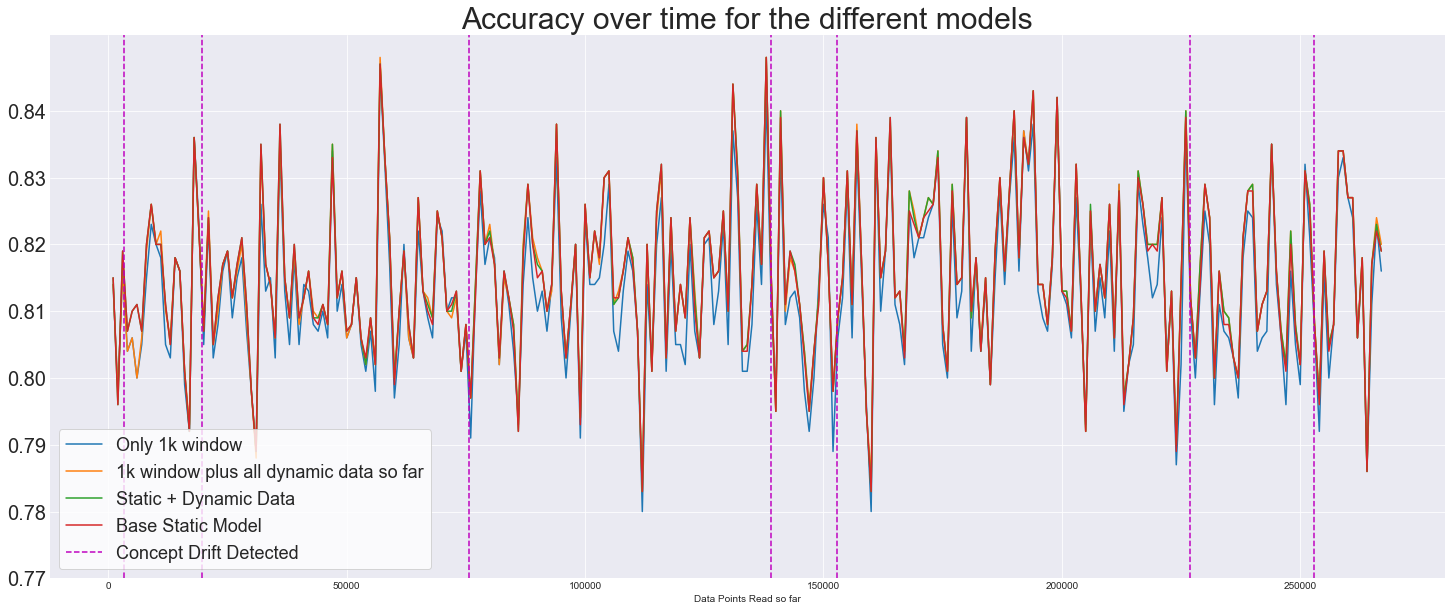

In [17]:
plt.figure(figsize=(25,10))
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_accuracies_only_1k[1:], label="Only 1k window")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_accuracies_1k_plus_dynamic_so_far[1:], label="1k window plus all dynamic data so far")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_accuracies_all_data[1:], label="Static + Dynamic Data")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], static_accuracies[1:], label = "Base Static Model")
#plt.plot([i for i in range(WINDOW_SIZE, 250000, WINDOW_SIZE)], ensemble_accuracies[1:], label = "Ensemble")

concept_drift_labeled = False
for xc in kswin_drift_indices:
    if not concept_drift_labeled:
        plt.axvline(x=xc, linestyle="--", color="m", label="Concept Drift Detected")
        concept_drift_labeled=True
    else:
        plt.axvline(x=xc, linestyle="--", color="m")

plt.legend(fontsize=18, frameon=1, facecolor="white")
plt.yticks([i/100 for i in range(77, 85)], fontsize=20)
plt.title("Accuracy over time for the different models", fontsize=30)
plt.xlabel("Data Points Read so far")
plt.show()

## Precision Metrics:

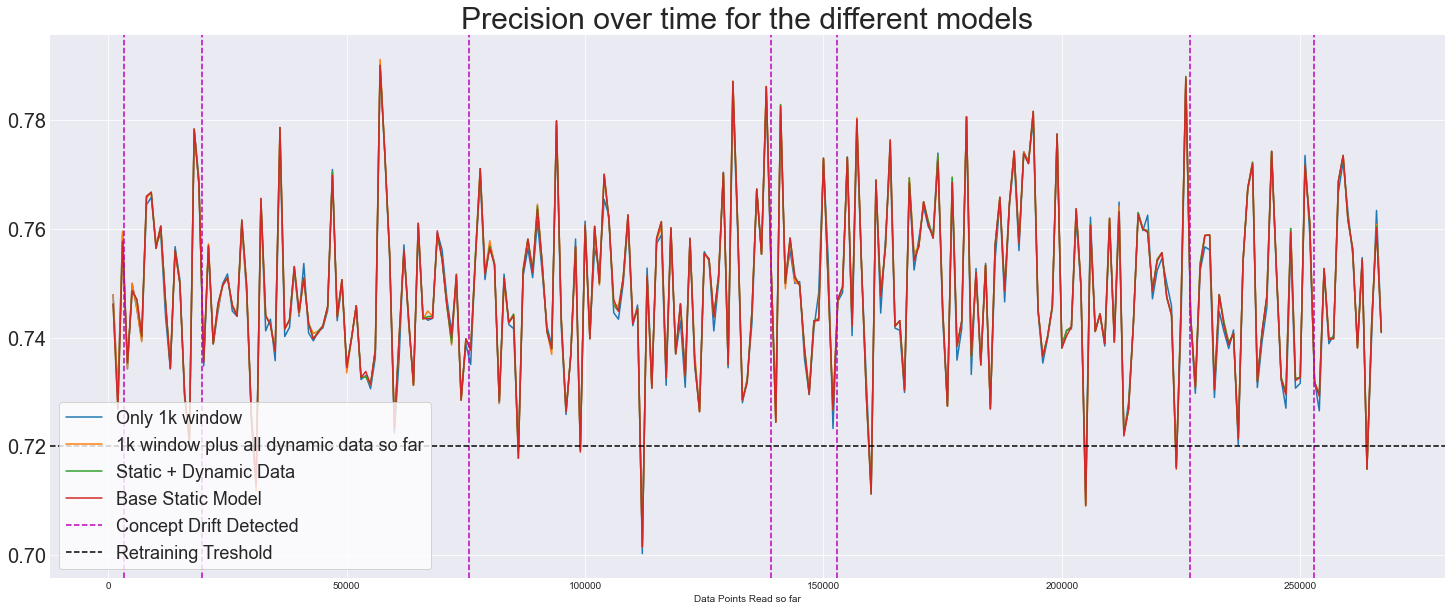

In [18]:
plt.figure(figsize=(25,10))
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_precisions_only_1k[1:], label="Only 1k window")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_precisions_1k_plus_dynamic_so_far[1:], label="1k window plus all dynamic data so far")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_precisions_all_data[1:], label="Static + Dynamic Data")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], static_precisions[1:], label = "Base Static Model")
#plt.plot([i for i in range(WINDOW_SIZE, 250000, WINDOW_SIZE)], ensemble_precisions[1:], label = "Ensemble")
concept_drift_labeled = False
for xc in kswin_drift_indices:
    if not concept_drift_labeled:
        plt.axvline(x=xc, linestyle="--", color="m", label="Concept Drift Detected")
        concept_drift_labeled=True
    else:
        plt.axvline(x=xc, linestyle="--", color="m")
plt.axhline(y=PRECISION_THRESHOLD, linestyle="--", color="k", label="Retraining Treshold")

plt.legend(fontsize=18, frameon=1, facecolor="white")

plt.title("Precision over time for the different models", fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel("Data Points Read so far")
plt.show()

## Recall Metrics

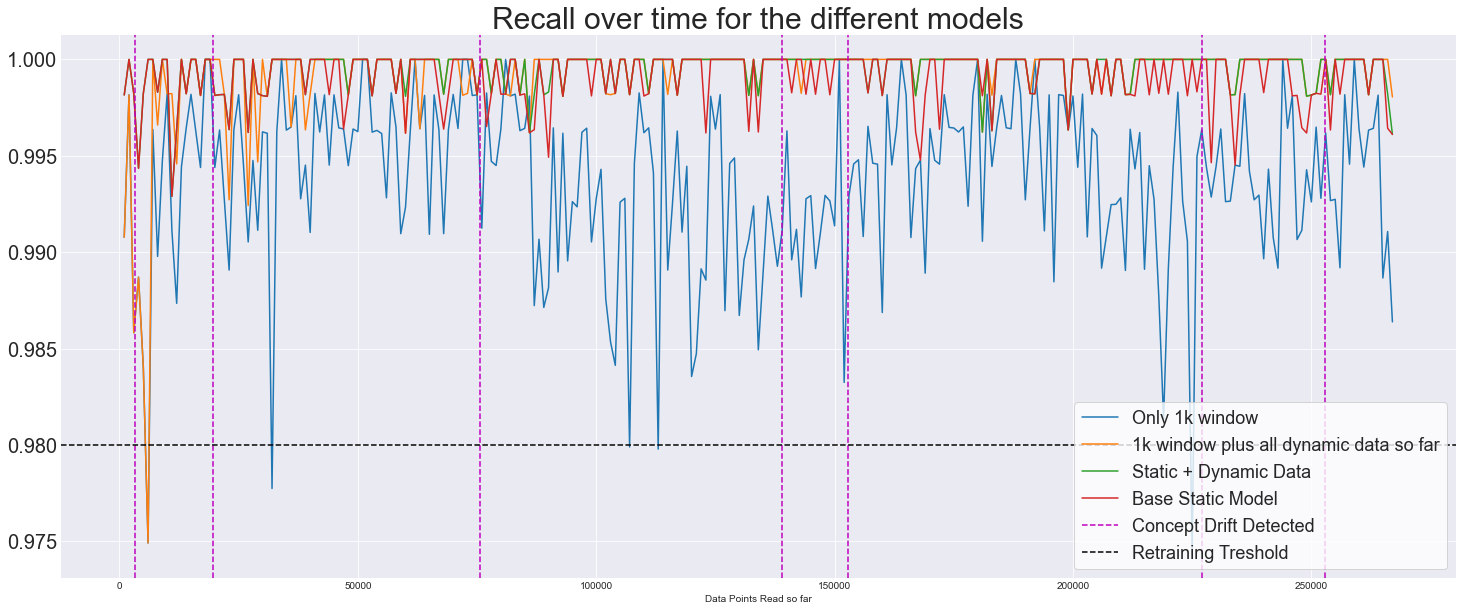

In [19]:
plt.figure(figsize=(25,10))
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_recalls_only_1k[1:], label="Only 1k window")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_recalls_1k_plus_dynamic_so_far[1:], label="1k window plus all dynamic data so far")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], dynamic_recalls_all_data[1:], label="Static + Dynamic Data")
plt.plot([i for i in range(WINDOW_SIZE, len(dynamic_accuracies_only_1k[1:])*WINDOW_SIZE+1, WINDOW_SIZE)], static_recalls[1:], label = "Base Static Model")
#plt.plot([i for i in range(WINDOW_SIZE, 250000, WINDOW_SIZE)], ensemble_recalls[1:], label = "Ensemble")
concept_drift_labeled = False
for xc in kswin_drift_indices:
    if not concept_drift_labeled:
        plt.axvline(x=xc, linestyle="--", color="m", label="Concept Drift Detected")
        concept_drift_labeled=True
    else:
        plt.axvline(x=xc, linestyle="--", color="m")
plt.axhline(y=RECALL_THRESHOLD, linestyle="--", color="k", label="Retraining Treshold")
#plt.xticks([i for i in range(0, 100000, WINDOW_SIZE)], rotation=90)
plt.legend(fontsize=18, frameon=1, facecolor="white")
#plt.yticks([i/100 for i in range(65, 80)])
plt.title("Recall over time for the different models", fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel("Data Points Read so far")
plt.show()

## Average Accuracy Metrics for raw accuracy, precision, and recall:

In [13]:
print("Average Accuracy: ")
print("Only 1k window: ", mean(dynamic_accuracies_only_1k[1:]))
print("1k window + all dynamic data seen so far : ", mean(dynamic_accuracies_1k_plus_dynamic_so_far[1:]))
print("All data (dynamic data seen so far +static)", mean(dynamic_accuracies_all_data[1:]))
print("Static Data:" ,mean(static_accuracies[1:]))

Average Accuracy: 
Only 1k window:  0.8129625468164794
1k window + all dynamic data seen so far :  0.815434456928839
All data (dynamic data seen so far +static) 0.8155280898876405
Static Data: 0.8153333333333334


In [14]:
print("Average Precision: ")
print("Only 1k window: ", mean(dynamic_precisions_only_1k[1:]))
print("1k window + all dynamic data seen so far : ", mean(dynamic_precisions_1k_plus_dynamic_so_far[1:]))
print("All data (dynamic data seen so far +static)", mean(dynamic_precisions_all_data[1:]))
print("Static Data:" ,mean(static_precisions[1:]))

Average Precision: 
Only 1k window:  0.7482212206440565
1k window + all dynamic data seen so far :  0.7487271630167517
All data (dynamic data seen so far +static) 0.7487093768816278
Static Data: 0.7486455023923755


In [15]:
print("Average Recall: ")
print("Only 1k window: ", mean(dynamic_recalls_only_1k[1:]))
print("1k window + all dynamic data seen so far : ", mean(dynamic_recalls_1k_plus_dynamic_so_far[1:]))
print("All data (dynamic data seen so far +static)", mean(dynamic_recalls_all_data[1:]))
print("Static Data:" ,mean(static_recalls[1:]))

Average Recall: 
Only 1k window:  0.9937514755831619
1k window + all dynamic data seen so far :  0.9991957635740077
All data (dynamic data seen so far +static) 0.9994990195777608
Static Data: 0.9991393915769885
